In [12]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path
from natsort import natsorted
import pandas as pd
import numpy as np
import zarr
# Save patches as independent files
data_dir = Path(os.environ['DATA_DIR'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
EXPERIMENTS = ['TS_5_4', 'TS_6_4', 'TS_69_2', 'TS_6_6', 'TS_73_6', 'TS_86_3',
       'TS_99_9']
OBJECT_NAMES = ['ribosome', 'virus-like-particle', 'beta-galactosidase',
         'beta-amylase', 'apo-ferritin', 'thyroglobulin']

In [3]:
def get_experiment_paths(data_dir, experiment):
    """
    Returns a dictionary with the following keys:
        - images: dictionary with the following keys:
            - denoised: path to the denoised zarr file
            - ctfdeconvolved: path to the ctfdeconvolved zarr file
            - isonetcorrected: path to the isonetcorrected zarr file
            - wbp: path to the wbp zarr file
        - jsons: dictionary with the following keys:
            - ribosome: path to the ribosome json file
            - virus-like-particle: path to the virus-like-particle json file
            - beta-galactosidase: path to the beta-galactosidase json file
            - beta-amylase: path to the beta-amylase json file
            - apo-ferritin: path to the apo-ferritin json file
            - thyroglobulin: path to the thyroglobulin json file
    """
    images = {}
    for file_type in ["denoised", "ctfdeconvolved", "isonetcorrected", "wbp"]:
        images[file_type] = data_dir / f"train/static/ExperimentRuns/{experiment}/VoxelSpacing10.000/{file_type}.zarr"
    jsons = {}
    for file_type in ["ribosome", "virus-like-particle", "beta-galactosidase", "beta-amylase", "apo-ferritin", "thyroglobulin"]:
        jsons[file_type] = data_dir / f"train/overlay/ExperimentRuns/{experiment}/Picks/{file_type}.json"
    return dict(images=images, jsons=jsons)

In [4]:
def convert_center_to_slicing(coords_center, dimensions, reverse_order=False):
    """
    Convert a center coordinate and dimensions to a slicing.
    If reverse_order is True, the slicing is returned in the reverse order.
    example
        input: np.array([150, 350, 550]), np.array([100, 100, 100])
        output: (slice(100,200), slice(300,400), slice(500,600))
    """
    dimensions = np.array(dimensions).astype(int)
    coords_center = np.array(coords_center).astype(int)
    half_dimensions = np.array(dimensions) // 2
    coords_min = coords_center - half_dimensions
    coords_max = coords_center - half_dimensions + dimensions
    slicing = tuple([slice(min_, max_) for min_, max_ in zip(coords_min, coords_max)])
    if reverse_order:
        return slicing[::-1]
    return slicing

In [5]:
def get_df_from_json(json_path):
    """
    For a given json file, returns a dataframe with the following columns:
        - pickable_object_name: one of "ribosome", "virus-like-particle", "beta-galactosidase",
            "beta-amylase", "apo-ferritin", or "thyroglobulin"
        - x: x coordinate of the point
        - y: y coordinate of the point
        - z: z coordinate of the point
        - instance_id, run_name, session_id, trust_orientation, unit, user_id, voxel_spacing, and transformation_
    """
    df = pd.read_json(json_path)
    df[["x", "y", "z"]] = df["points"].apply(lambda x: pd.Series(x["location"])[["x", "y", "z"]])
    df["instance_id"] = df["points"].apply(lambda x: x["instance_id"])
    df["transformation_"] = df["points"].apply(lambda x: str(x["transformation_"]))
    return df[df.columns.difference(["points"])].copy()


In [6]:
def get_objects(data_dir, experiment):
    """
    For a given experiment, returns a dataframe with the following columns:
        - pickable_object_name: one of "ribosome", "virus-like-particle", "beta-galactosidase",
            "beta-amylase", "apo-ferritin", or "thyroglobulin"
        - x: x coordinate of the point
        - y: y coordinate of the point
        - z: z coordinate of the point
        - instance_id, run_name, session_id, trust_orientation, unit, user_id, voxel_spacing, and transformation
    """
    paths = get_experiment_paths(data_dir, experiment)
    file_types = ["ribosome", "virus-like-particle", "beta-galactosidase", "beta-amylase", "apo-ferritin", "thyroglobulin"]
    dfs = [get_df_from_json(paths["jsons"][file_type]) for file_type in file_types]
    df = pd.concat(dfs, ignore_index=True)
    return df

In [7]:
def crop_objects(data_dir, experiment, image_type, object_name, dimensions):
    paths = get_experiment_paths(data_dir, experiment)
    zarr_path = paths["images"][image_type]
    zarray = zarr.open(data_dir / zarr_path)[0]
    objects = get_objects(data_dir, experiment).query(f"pickable_object_name == '{object_name}'")
    objects["slicing"] = objects[["z", "y", "x"]].apply(lambda x: convert_center_to_slicing(x/10, dimensions), axis=1)
    crops = []
    for slicing in objects["slicing"]:
        crops.append(zarray[slicing])
    return crops

In [8]:
def get_all_crops(data_dir, image_type, object_name, dimensions):
    crops = {}
    for experiment in EXPERIMENTS:
        crops[experiment] = crop_objects(data_dir, experiment, image_type, object_name, dimensions)
    return crops

In [9]:
objects = pd.read_csv(data_dir / 'objects.csv')
objects

,experiment,particle_type,x,y,z
0,TS_5_4,ribosome,4601.271,601.066,600.934
1,TS_5_4,ribosome,4803.789,455.425,514.016
2,TS_5_4,ribosome,4715.436,825.374,802.166
3,TS_5_4,ribosome,5003.275,782.745,802.480
4,TS_5_4,ribosome,710.459,3815.845,1405.435
...,...,...,...,...,...
1264,TS_99_9,thyroglobulin,2790.000,3945.000,790.000
1265,TS_99_9,thyroglobulin,1110.308,5734.615,862.154
1266,TS_99_9,thyroglobulin,3148.098,3234.683,952.634
1267,TS_99_9,thyroglobulin,1541.778,4082.630,989.996


In [10]:
zarr_files = pd.read_csv(data_dir / 'zarr_files.csv')
zarr_files

,path,split,file_type,spacing,experiment
0,test/static/ExperimentRuns/TS_5_4/VoxelSpacing...,test,denoised.zarr,VoxelSpacing10.000,TS_5_4
1,test/static/ExperimentRuns/TS_6_4/VoxelSpacing...,test,denoised.zarr,VoxelSpacing10.000,TS_6_4
2,test/static/ExperimentRuns/TS_69_2/VoxelSpacin...,test,denoised.zarr,VoxelSpacing10.000,TS_69_2
3,train/static/ExperimentRuns/TS_5_4/VoxelSpacin...,train,ctfdeconvolved.zarr,VoxelSpacing10.000,TS_5_4
4,train/static/ExperimentRuns/TS_5_4/VoxelSpacin...,train,denoised.zarr,VoxelSpacing10.000,TS_5_4
5,train/static/ExperimentRuns/TS_5_4/VoxelSpacin...,train,isonetcorrected.zarr,VoxelSpacing10.000,TS_5_4
6,train/static/ExperimentRuns/TS_5_4/VoxelSpacin...,train,wbp.zarr,VoxelSpacing10.000,TS_5_4
7,train/static/ExperimentRuns/TS_6_4/VoxelSpacin...,train,ctfdeconvolved.zarr,VoxelSpacing10.000,TS_6_4
8,train/static/ExperimentRuns/TS_6_4/VoxelSpacin...,train,denoised.zarr,VoxelSpacing10.000,TS_6_4
9,train/static/ExperimentRuns/TS_6_4/VoxelSpacin...,train,isonetcorrected.zarr,VoxelSpacing10.000,TS_6_4


In [11]:
shape = (32,32,32)
for object_name in OBJECT_NAMES:
    parent_dir = data_dir / "patches" / object_name
    parent_dir.mkdir(exist_ok=True, parents=True)
    crops = get_all_crops(data_dir, "denoised", object_name, shape)
    for experiment in EXPERIMENTS:
        for i, crop in enumerate(crops[experiment]):
            if crop.size:
                if crop.shape != shape:
                    new_array = np.zeros((32,32,32))
                    new_array[:crop.shape[0],:crop.shape[1],:crop.shape[2]] = crop
                    crop = new_array
                    print(f"Reshaped crop for {experiment}_{object_name}_{i}")
                np.save(parent_dir / f"{experiment}_{object_name}_{i}.npy", crop)
            else:
                print(f"Empty crop for {experiment}_{object_name}_{i}")


Reshaped crop for TS_5_4_ribosome_27
Empty crop for TS_6_4_ribosome_15
Empty crop for TS_6_4_ribosome_16
Empty crop for TS_6_4_ribosome_44
Empty crop for TS_6_4_ribosome_53
Empty crop for TS_6_4_ribosome_68
Reshaped crop for TS_69_2_ribosome_2
Reshaped crop for TS_69_2_ribosome_31
Empty crop for TS_73_6_ribosome_0
Empty crop for TS_73_6_ribosome_4
Reshaped crop for TS_86_3_ribosome_2
Reshaped crop for TS_86_3_ribosome_3
Empty crop for TS_86_3_ribosome_36
Empty crop for TS_99_9_ribosome_22
Empty crop for TS_99_9_ribosome_23
Empty crop for TS_5_4_virus-like-particle_3
Reshaped crop for TS_5_4_virus-like-particle_10
Empty crop for TS_6_4_virus-like-particle_1
Reshaped crop for TS_6_6_virus-like-particle_6
Reshaped crop for TS_73_6_virus-like-particle_4
Empty crop for TS_73_6_virus-like-particle_6
Empty crop for TS_86_3_virus-like-particle_0
Reshaped crop for TS_86_3_virus-like-particle_1
Empty crop for TS_5_4_beta-galactosidase_6
Empty crop for TS_69_2_beta-galactosidase_1
Reshaped crop f

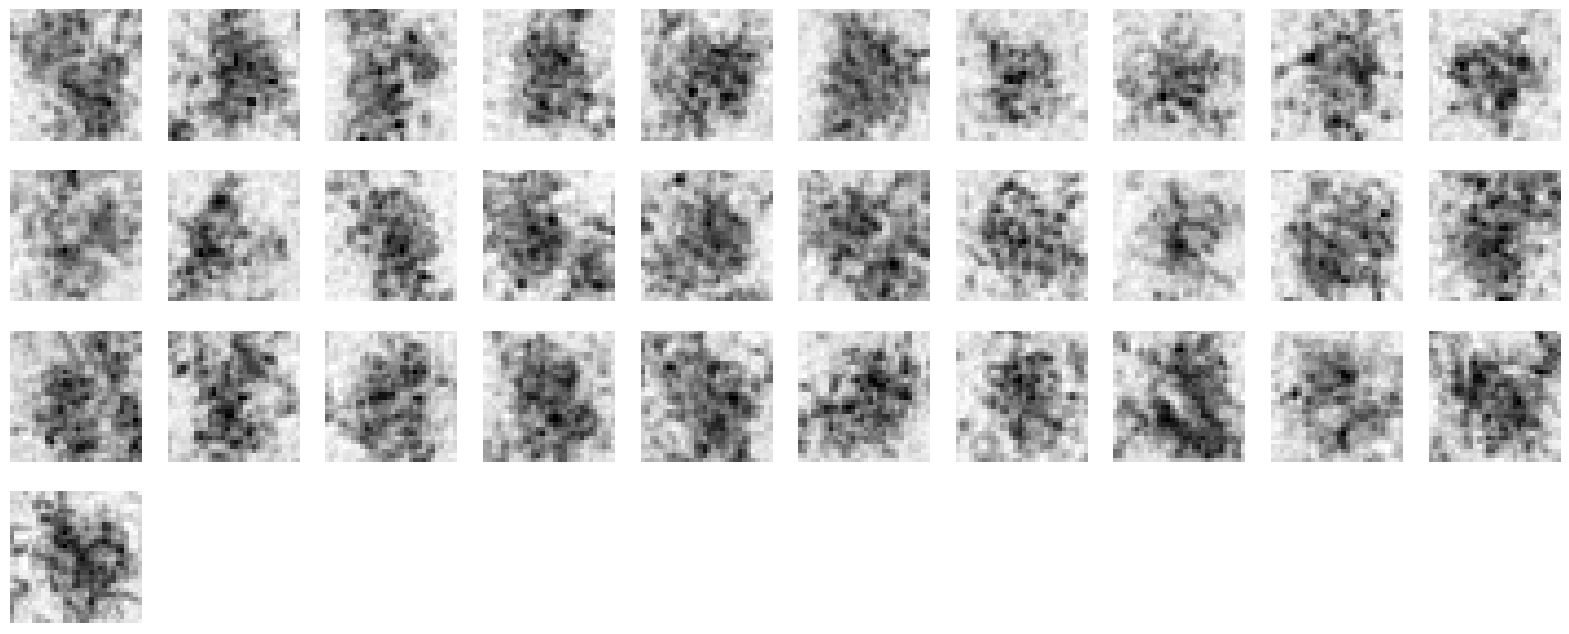

In [13]:
import matplotlib.pyplot as plt
crops = crop_objects(data_dir, "TS_5_4", "denoised", "ribosome", [30, 30, 30])

n = len(crops)
nrows = int(np.ceil(n / 10))
ncols = 10
fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))

axi = axs.flat
for crop in crops:
    plt.sca(next(axi))
    plt.imshow(crop.min(axis=0), cmap="gray")
axi = axs.flat
for ax in axi:
    ax.axis("off")